In [1]:
import sys
# Sorry for this code : (
sys.path.append('../')

import os
import numpy as np
from matplotlib import pyplot as plt
from settings import Params

def load_experiment(name, newest=False):
    core = 0
    batch = 0

    if newest:
        children = os.listdir("../hearts/")
        
        new_name = None
        suffix = -1
        for child in children:
            child_name = child.split("-")

            if len(child_name) == 1:
                if new_name is None and child_name[0] == name:
                    new_name = child_name[0]
                    suffix = 0
                continue

            child_suffix = int(child_name[1])
            if child_name[0] == name and child_suffix > suffix:
                new_name = child
                suffix = child_suffix
        
        if new_name is None:
            raise ValueError(f"Heart wiht name {name} does not exist")
        
        name = new_name
        
    par = Params(f"../hearts/{name}/params.json")
    t_start = par.get("t_start")
    t_end = par.get("t_end")

    states = np.load(f"../hearts/{name}/data/states_{core}_{batch}.npy")
    actions = np.load(f"../hearts/{name}/data/actions_{core}_{batch}.npy")

    return states, actions, t_start, t_end, par, name


ref_non_disturbed
ref_non_disturbed


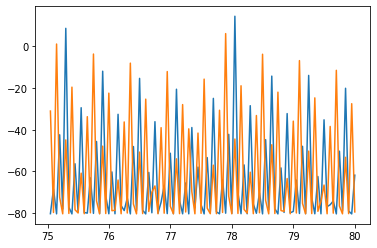

In [12]:
states, actions, t_start, t_end, par, name = load_experiment("ref_non_disturbed", newest=True)

uProbes = states
probeUndisturbed = states.T[1]
t = np.linspace(t_start, t_end, num=probeUndisturbed.size) / 1000

indicies = t > 75

plt.plot(t[indicies], states.T[1][indicies])
plt.plot(t[indicies], states.T[0][indicies])

ref_disturbed


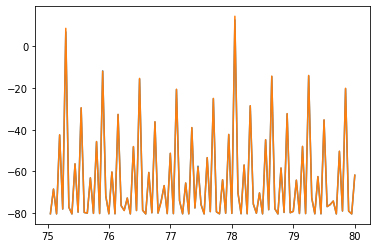

In [13]:
states, actions, t_start, t_end, par, _ = load_experiment("ref_disturbed")

dProbes = states
probeDisturbed = states.T[1]
t = np.linspace(t_start, t_end, num=probeDisturbed.size) / 1000

indicies = t > 75

plt.plot(t[indicies], probeDisturbed[indicies])
plt.plot(t[indicies], probeUndisturbed[indicies])

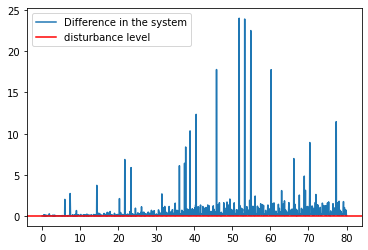

In [15]:
diffs = np.linalg.norm(dProbes - uProbes, axis=1)

N = 2
diffs_mean = np.convolve(diffs, np.ones(N)/N, mode='sane')

t = np.linspace(t_start, t_end, num=diffs.size) / 1_000
#plt.plot(t, diffs, label="actual")
plt.plot(t, diffs, label="Difference in the system")
plt.axhline(1e-3, color="red", label="disturbance level")
plt.legend()


reference_signal


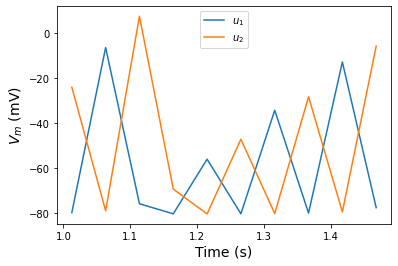

In [28]:
states, actions, t_start, t_end, par, name = load_experiment("reference_signal")

t = np.linspace(t_start, t_end, num=states.shape[0]) / 1000

indicies = (t > 1) & (t < 1.5)

showcase = states.T
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$V_m$ (mV)", fontsize=14)
plt.plot(t[indicies], showcase[0][indicies], label="$u_1$")
#plt.plot(t[indicies], showcase[2][indicies])
plt.plot(t[indicies], showcase[4][indicies], label="$u_2$")
plt.legend()
plt.savefig("../../Figures/ref-signal-example.pdf")

In [25]:
actions

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])